# Verifying MGC and DCORR under restricted permutations

Note, the `neurodata/scipy` implementations has been locally modified to take into account group structure. DCORR is derived from this by mandating a global scale.

In [1]:
import sys, os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
%matplotlib inline

sys.path.append(os.path.realpath('..'))
from hyppo.independence import Dcorr
from hyppo.ksample._utils import k_sample_transform
from scipy.spatial.distance import squareform, pdist
from scipy.stats import multiscale_graphcorr
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

### within case

In [9]:
n = 40
d = 4
n_datasets = 200

# i.e. Experts rest vs. experts compassion
m = 2
datasets_within_11 = []
for i in range(n_datasets):
    np.random.seed(i)
    mus = np.random.normal(0,1,(n,d))
    X = np.vstack(
        [np.random.normal(mu,0.1,(m,d)) for mu in mus]
    )
    datasets_within_11.append(X)
Y_within_11 = np.hstack([[0,1] for _ in range(n)])
groups_within_11 = np.hstack(
    [[f'{i}']*m for i in range(n)]
)

In [10]:
pvalues_mgc_within_11 = []
for X in datasets_within_11:
    _,pval,_ = multiscale_graphcorr(
        X,Y_within_11,
        reps=100,
        workers=-1,
        random_state=1,
        permute_groups=groups_within_11,
        permute_structure='within',
        global_corr='mgc_restricted'
    )
    pvalues_mgc_within_11.append(pval)

In [11]:
pvalues_dcorr_within_11 = []
for X in datasets_within_11:
    _,pval,_ = multiscale_graphcorr(
        X,Y_within_11,
        reps=100,
        workers=-1,
        random_state=1,
        permute_groups=groups_within_11,
        permute_structure='within',
        global_corr='mgc_restricted',
        full_scale=True,
    )
    pvalues_dcorr_within_11.append(pval)

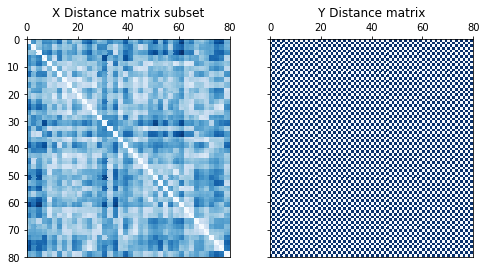

In [12]:
fig,axes = plt.subplots(1,2,sharey=True,figsize=(8,4))

axes[0].pcolor(squareform(pdist(X)), cmap=plt.cm.Blues)
# want a more natural, table-like display
axes[0].invert_yaxis()
axes[0].xaxis.tick_top()
axes[0].set_title('X Distance matrix subset')

axes[1].pcolor(squareform(pdist(Y_within_11[:,None])), cmap=plt.cm.Blues)
# want a more natural, table-like display
axes[1].xaxis.tick_top()
axes[1].set_title('Y Distance matrix')


plt.show()

Text(0.5, 1.02, 'MGC vs. DCORR 2sample pvalue distribution (100 reps, 250 datasets, permute within subject)')

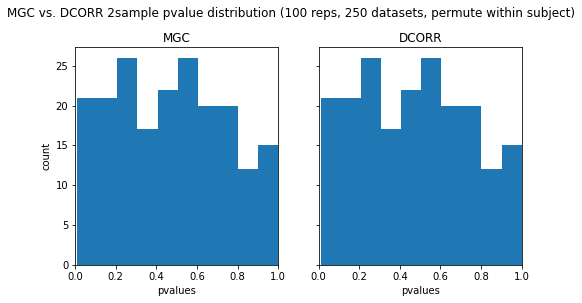

In [13]:
fig,axes = plt.subplots(1,2,sharey=True,figsize=(8,4))
axes[0].hist(pvalues_mgc_within_11)
axes[1].hist(pvalues_dcorr_within_11)
axes[0].set_ylabel('count')
axes[0].set_xlabel('pvalues')
axes[1].set_xlabel('pvalues')
axes[0].set_title('MGC')
axes[1].set_title('DCORR')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)
fig.suptitle('MGC vs. DCORR 2sample pvalue distribution (100 reps, 250 datasets, permute within subject)', y=1.02)

### Across case

In [2]:
n = 40
d = 100
n_datasets = 200
pair_std = 0

# i.e. Novices meditating vs. experts meditating
datasets_across_22 = []
m = 2
for i in range(n_datasets):
    np.random.seed(i)
    mus = np.random.normal(0,1,(n,d))
    X = np.vstack(
        [np.random.normal(mu,pair_std,(m,d)) for mu in mus]
    )
    datasets_across_22.append(X)
Y_across_22 = np.hstack(
    [[0] for _ in range(int(n/2)*m)] +
    [[1] for _ in range(int(n/2)*m)]
)
groups_across_22 = np.hstack(
    [[f'{i}']*(m) for i in range(n)]
)

In [3]:
pvalues_mgc_zeroed_across_22 = []
opt_scales_mgc_zeroed_across_22 = []
nulls_scales_mgc_zeroed_across_22 = []
for X in datasets_across_22:
    stat,pval,mgc_dict = multiscale_graphcorr(
        X,Y_across_22,
        reps=100,
        workers=-1,
        random_state=1,
        permute_groups=groups_across_22,
        permute_structure='across',
        global_corr='mgc_restricted',
    )
    opt_scales_mgc_zeroed_across_22.append(mgc_dict['opt_scale'])
    nulls_scales_mgc_zeroed_across_22.append(mgc_dict['null_dist'])
    pvalues_mgc_zeroed_across_22.append(pval)

In [4]:
pvalues_mgc_across_22 = []
opt_scales_mgc_across_22 = []
nulls_scales_mgc_across_22 = []
for X in datasets_across_22:
    stat,pval,mgc_dict = multiscale_graphcorr(
        X,Y_across_22,
        reps=100,
        workers=-1,
        random_state=1,
        permute_groups=groups_across_22,
        permute_structure='across',
        #global_corr='mgc_restricted',
    )
    opt_scales_mgc_across_22.append(mgc_dict['opt_scale'])
    nulls_scales_mgc_across_22.append(mgc_dict['null_dist'])
    pvalues_mgc_across_22.append(pval)

In [5]:
pvalues_dcorr_across_22 = []
for X in datasets_across_22:
    _,pval,_ = multiscale_graphcorr(
        X,Y_across_22,
        reps=100,
        workers=-1,
        random_state=1,
        permute_groups=groups_across_22,
        permute_structure='across',
        full_scale=True,
        global_corr='mgc_restricted'
    )
    pvalues_dcorr_across_22.append(pval)

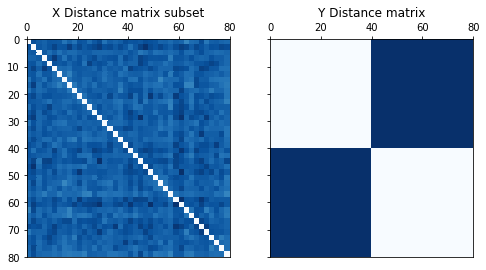

In [6]:
fig,axes = plt.subplots(1,2,sharey=True,figsize=(8,4))

axes[0].pcolor(squareform(pdist(X)), cmap=plt.cm.Blues)
# want a more natural, table-like display
axes[0].invert_yaxis()
axes[0].xaxis.tick_top()
axes[0].set_title('X Distance matrix subset')

axes[1].pcolor(squareform(pdist(Y_across_22[:,None])), cmap=plt.cm.Blues)
# want a more natural, table-like display
axes[1].xaxis.tick_top()
axes[1].set_title('Y Distance matrix')

plt.show()

Text(0.5, 1.02, '2sample pvalue distributions (100 reps, 200 datasets, permute group together)')

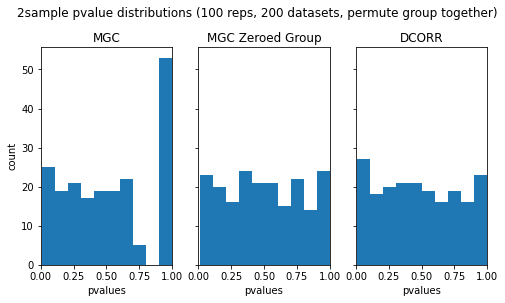

In [7]:
fig,axes = plt.subplots(1,3,sharey=True,figsize=(8,4))
axes[0].hist(pvalues_mgc_across_22)
axes[0].set_ylabel('count')
axes[0].set_xlabel('pvalues')
axes[0].set_title('MGC')
axes[0].set_xlim(0,1)

axes[1].hist(pvalues_mgc_zeroed_across_22)
axes[1].set_xlabel('pvalues')
axes[1].set_title('MGC Zeroed Group')
axes[1].set_xlim(0,1)

axes[2].hist(pvalues_dcorr_across_22)
axes[2].set_xlabel('pvalues')
axes[2].set_title('DCORR')
axes[2].set_xlim(0,1)
fig.suptitle('2sample pvalue distributions (100 reps, 200 datasets, permute group together)', y=1.02)